<br>

# 추천 시스템 : Session based Recommendation <br>
---

<br>

In [40]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

<br>

## 데이터 확인 <br><br>

The GroupLens Research 의 MovieLens 데이터 사용 <br>
( Movielens 1M Dataset )
```
wget http://files.grouplens.org/datasets/movielens/ml-1m.zip
```

<br>

In [41]:
# 데이터 설명(README)를 읽어 봅니다.
 
import os
f = open(os.getenv('HOME')+'/aiffel/movie_recommendation/ml-1m/README.txt', 'r')
while True:
    line = f.readline()
    if not line: break
    print(line)
f.close()

SUMMARY




These files contain 1,000,209 anonymous ratings of approximately 3,900 movies 

made by 6,040 MovieLens users who joined MovieLens in 2000.



USAGE LICENSE




Neither the University of Minnesota nor any of the researchers

involved can guarantee the correctness of the data, its suitability

for any particular purpose, or the validity of results based on the

use of the data set.  The data set may be used for any research

purposes under the following conditions:



     * The user may not state or imply any endorsement from the

       University of Minnesota or the GroupLens Research Group.



     * The user must acknowledge the use of the data set in

       publications resulting from the use of the data set

       (see below for citation information).



     * The user may not redistribute the data without separate

       permission.



     * The user may not use this information for any commercial or

       revenue-bearing purposes without first obtaining permi

<br>

### 데이터 Description <br><br>

---
RATINGS FILE DESCRIPTION <br>

All ratings are contained in the file "ratings.dat" and are in the <br>
following format: <br>

UserID::MovieID::Rating::Timestamp <br>

- UserIDs range between 1 and 6040 <br>
- MovieIDs range between 1 and 3952 <br>
- Ratings are made on a 5-star scale (whole-star ratings only) <br>
- Timestamp is __represented in seconds__ since the epoch as returned by time(2) <br>
- Each user has at least 20 ratings <br>
---
<br>

- SessionID 대신 UserID 칼럼 <br>

    이 데이터셋은 명확한 1회 세션의 SessionID를 포함하지 않고 있습니다. <br>
    이번에는 UserID가 SessionID 역할을 해야 합니다. <br><br>


- Rating 정보가 포함 <br>

    이전 실습내역에서는 rating 정보가 없어 무시하였습니다. <br>
    하지만, 직전에 봤던 영화가 맘에 들었는지 여부가 비슷한 영화를 더 고르게 하는 것과 상관이 있을 수도 있습니다. 아울러, Rating이 낮은 데이터를 어떻게 처리할지도 고민해야 합니다. <br><br>


- Time 항목에는 UTC time 가 포함 <br>

    1970년 1월 1일부터 경과된 초단위 시간이 기재되어 있습니다.

<br>

<br>

## Data Preprocess

<br>

<br>

### 데이터 읽어오기

<br>

In [42]:
# 데이터 파일 경로

data_path = Path(os.getenv('HOME')+'/aiffel/movie_recommendation/ml-1m') 
train_path = data_path / 'ratings.dat'
train_path

PosixPath('/home/ssac29/aiffel/movie_recommendation/ml-1m/ratings.dat')

In [43]:
# 데이터 읽어오기# 판다스 데이터프레임으로 불러와
# 필요한 칼럼만 저장하는 함수 작성

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'MovieId', 'Rating', 'Time']
    return data

In [44]:
# 데이터 불러오기
# 시간이 좀 걸릴 수 있습니다. 메모리도 10GB 가까이 소요될 수 있으니 메모리 상태에 주의해 주세요. 

data = load_data(train_path, None)
# data를 id와 시간 순서로 정렬
data.sort_values(['UserId', 'Time'], inplace=True)
data

,UserId,MovieId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


<br>

### 데이터 분석 <br><br>


추천시스템을 구축할 때 가장 먼저 확인해 볼 것 <br>

- 유저수(세션 수) <br>
참고. 같은 유저가 여러개의 세션을 만들 수도 있습니다

- 아이템 수

<br>

In [45]:
# 유저 수, 아이템 수 확인

data['UserId'].nunique(), data['MovieId'].nunique()

(6040, 3706)

<br>

'Rating' 칼럼의 null 값 확인

<br>

In [46]:
# 'Rating' 칼럼의 null 데이터 확인

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 31 to 1000042
Data columns (total 4 columns):
 #   Column   Non-Null Count    Dtype
---  ------   --------------    -----
 0   UserId   1000209 non-null  int32
 1   MovieId  1000209 non-null  int32
 2   Rating   1000209 non-null  int32
 3   Time     1000209 non-null  int64
dtypes: int32(3), int64(1)
memory usage: 26.7 MB


<br>

### 데이터 변환 : UTC Time to Date <br>

1970-01-01 기준 누적 seconds로 계산된 ‘unix’ (or POSIX) timestamp 데이터셋을 <br>
판다스 datetime 데이터 객체로 변환 <br>

- pandas.to_datetime 매서드 이용 <br>

    ```pandas.to_datetime(arg, errors='raise', dayfirst=False, yearfirst=False, utc=None, format=None, exact=True, unit=None, infer_datetime_format=False, origin='unix', cache=True)``` <br><br>

    __arg__ : int, float, str, datetime, list, tuple, 1-d array, Series, DataFrame/dict-like <br>

    The object to convert to a datetime. <br><br>

    ... <br><br>

    __unit__ : str, default ‘ns’ <br>

    The unit of the arg (D,s,ms,us,ns) denote the unit, which is an integer or float number. This will be based off the origin. Example, with unit=’ms’ and origin=’unix’ (the default), this would calculate the number of milliseconds to the unix epoch start. <br><br>

    __origin__ : scalar, default ‘unix’ <br>
    
    Define the reference date. The numeric values would be parsed as number of units (defined by unit) since this reference date. <br>

    - If ‘unix’ (or POSIX) time; origin is set to 1970-01-01. <br><br>


참고. <br>
[pandas.to_datetime API reference](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html)

<br>

In [47]:
# 'Time' 칼럼 데이터 datetime 객체로 변환

data['Time'] = pd.to_datetime(data['Time'], unit='s', origin='unix')

data.head(55)

,UserId,MovieId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
36,1,1836,5,2000-12-31 22:02:52
3,1,3408,4,2000-12-31 22:04:35
7,1,2804,5,2000-12-31 22:11:59
47,1,1207,4,2000-12-31 22:11:59
0,1,1193,5,2000-12-31 22:12:40


<br>

### 데이터 분석 : User Length <br><br>


각 유저별로 몇 개의 영화에 rating 했는지 확인 <br>
같은 'UserId' 를 키로 갖는 데이터 row 의 개수 확인 <br><br>

- UserId : 로그인 하여 활동하는 유저의 아이디 <br>

    로그인 하여 활동하는 사용자에 대해서 알 수 있음 <br>
    ( 따로 SessionId 정보가 없을 경우 세션 사용자의 활동은 알 수 없음 )

<br>

In [48]:
# 각 유저별 rating 참여한 MovieId 데이터 수 확인

user_length = data.groupby('UserId').size()
user_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [49]:
# 유저별 행동 수의 평균 및 최대값 확인

user_length.median(), user_length.mean(), user_length.max()

(96.0, 165.5975165562914, 2314)

In [50]:
# 사분위 분포 확인

user_length.quantile(0.999)

1343.181000000005

<br>

#### 데이터 분포 시각화 <br><br>

Session Length 데이터 길이에 대해 더 잘 이해하고, <br>
이상치를 직관적으로 파악하기 위해 데이터 분포를 시각화

<br>

(array([860., 574., 505., 359., 337., 247., 249., 230., 206., 177., 152.,
        153., 135., 116.,  93.,  98., 103.,  78.,  79.,  64.,  61.,  65.,
         48.,  59.,  70.,  62.,  46.,  39.,  28.,  41.,  26.,  34.,  36.,
         44.,  26.,  26.,  23.,  16.,  24.,  17.,  24.,  15.,  29.,  16.,
         20.,  15.,  20.,  10.,   8.,  14.,   7.,  15.,  11.,  13.,   7.,
          6.,   8.,  11.,   6.,   9.,   4.,  16.,   6.,   6.,   8.,   5.,
          6.,   7.,   2.,   7.,   7.,   7.,   7.,   6.,   5.,   5.,   5.,
          2.,   3.,   2.,   4.,   2.,   4.,   1.,   1.,   4.,   3.,   3.,
          1.,   2.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,   1.,   1.,
          1.,   2.,   0.,   0.,   1.,   4.,   1.,   2.,   1.,   1.,   2.,
          1.,   1.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 

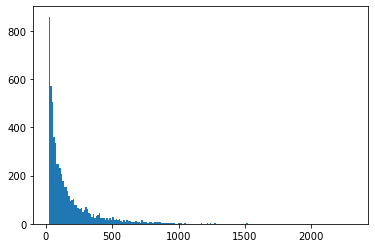

In [39]:
# rating 참여한 movies 개수에 따른 user 의분포 시각화

plt.hist(user_length, bins=200)

In [34]:
# 데이터 분포 그래프를 위한 빈도별 분포 계산

# 전체 데이터의 누적 빈도
length_count = user_length.groupby(user_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()

# 전체 분포의 누적 빈도 99.9% 미만인 데이터들의 빈도
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

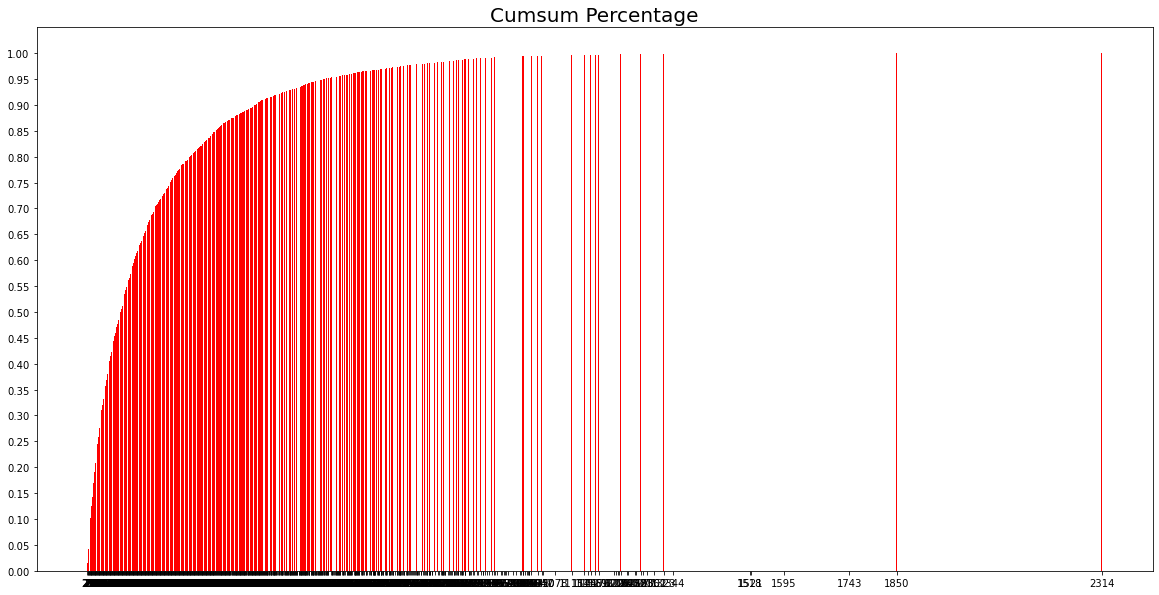

In [32]:
# 데이터 분포 그래프 시각화

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum.index,
        height=length_percent_cumsum, color='red')
plt.xticks(length_percent_cumsum.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage', size=20)
plt.show()

<br>

- 각 세션의 길이 (클릭 수)는 보통 100 ~ 200 정도 입니다. <br>
로그인한 유저의 활동은 일반 세션 하나의 활동 평균 보다 활동성이 높습니다. <br>

- 99.9%의 유저는 길이가 1343 이하입니다. <br>

- 길이가 1850, 2314 인 유저는 뭔가 이상할 수도 있습니다.

<br>

<br>

#### 데이터 평가 <br>

- __data sparsity 문제__ <br>

    Session Length 데이터를 가지고는 __Matrix Factorization__ 모델 사용 어려움 <br>
    
    User * Item Matrix의 빈칸이 너무 많아서 모델이 제대로 학습되지 않을 가능성이 있다. <br> 이 세션정보는 유저를 ID 기반으로 정리할 수 없기 때문에 세션 하나를 유저 하나로 본다면 기존의 유저-상품정보 Matrix보다 훨씬 sparse한 형태가 된다. <br><br>


- __Matrix Factorization (행렬 인수분해) 모델__ <br>

    추천시스템에 널리 사용되는 모델 중 하나 <br>
    전형적 추천시스템 모델인 __Nearest-Neighber (최근접 이웃)__ 기술보다 월등 <br>

    항목 등급 패턴으로부터 유추된 요소 벡터에 의해 항목과 사용자 모두를 특성화 <br>
    항목과 사용자 요인 간 높은 일치성을 보이는 것을 추천 <br>

    참고. <br>
    [Matrix Factorization 기술을 이용한 넷플릭스 추천 시스템](https://medium.com/curg/matrix-factorization-%EA%B8%B0%EC%88%A0%EC%9D%84-%EC%9D%B4%EC%9A%A9%ED%95%9C-%EB%84%B7%ED%94%8C%EB%A6%AD%EC%8A%A4-%EC%B6%94%EC%B2%9C-%EC%8B%9C%EC%8A%A4%ED%85%9C-7455a40ad527) <br>
    [[Recommender System] - MF 모델과 ALS 모델](https://yamalab.tistory.com/89)
    
<br>

<br>

### 데이터 분석 : Session Time <br><br>


데이터의 시간 관련 정보를 확인 <br>
기존 데이터에는 6개월치 데이터 존재 <br><br>

- 약 3년치(34개월) 일별 데이터 'Time' 칼럼 확인 <br>

- 1개월치 데이터만 사용하기 위해 'Time' 칼럼 데이터 수정 <br>
( 기간이 너무 짧아 특정 유저의 데이터만 존재할 수 있으므로 추후 수정가능성 )

<br>

In [51]:
# 원본 데이터의 시간 관련 정보 확인

oldest, latest = data['Time'].min(), data['Time'].max()

print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


<br>

#### 판다스 Timestamp 객체 <br>

latest는 Timestamp 객체이기 때문에 int 객체와의 사칙연산을 지원하지 않습니다. <br>
날짜끼리의 차이를 구하고 싶을 때는 datetime 라이브러리의 timedelta 객체를 사용 <br>

- 데이터프레임.timedelta(기간) <br>
    기간 일자 만큼 이전의 Timestamp 데이터 리턴 (?) <br>

- 판다스 Timestamp 객체사이 - 연산 : 차이 만큼의 이전 날짜 객체 리턴

<br>

In [17]:
type(latest)

pandas._libs.tslibs.timestamps.Timestamp

In [19]:
# 30일 간격으로 한달치 데이터로 수정
# 총 데이터 개수가 많지 않으므로 3년치 전체 데이터 전부 사용 !
"""
# 최종 날짜로부터 30일 이전 날짜 계산
month_ago = latest - dt.timedelta(180)

# 방금 구한 날짜 이후의 데이터만 저장 (최근 한달치 데이터)
data = data[data['Time'] > month_ago]

data
"""

,UserId,MovieId,Rating,Time
28225,195,2808,3,2003-02-02 21:08:38
27759,195,1254,4,2003-02-06 17:23:42
27921,195,1456,2,2003-02-08 00:07:32
28443,195,468,3,2003-02-11 17:42:36
28255,195,2748,1,2003-02-11 18:23:28
...,...,...,...,...
984731,5950,3948,4,2003-02-27 18:13:57
984682,5950,3578,4,2003-02-27 18:14:30
984475,5950,3793,3,2003-02-27 18:15:10
984660,5950,3555,2,2003-02-27 18:15:37


<br>

### 시간 관련 데이터의 특성 <br>

시간에 따른 소비 패턴의 변화 <br>
시간과 관련된 추천시스템은 최근 소비 트렌드를 학습하는 것이 중요 ! <br><br>


#### 시간 관련 데이터의 유형들 <br>

- 데이터 생성 날짜 <br>

- 접속하는 시간대 <br>

- 접속해 있는 시간 <br>

- 접속하는 요일 <br>

- 마지막 접속 시간 <br>

- 장바구니에 넣고 지난 시간 <br>

- 계절 등 ...

<br>

<br>

### 데이터 전처리 <br>

<br>

<br>

### 데이터 전처리 : 이상치 제거 <br>

- 클릭 수 너무 적은 세션(유저) 제거 <br>

    Session Length 길이가 1 인 세션 제거 <br>
    유저가 최소 1개 이상 클릭했을 때 다음 클릭을 예측하려 하기 때문 <br><br>

- 클릭 수가 너무 적은 아이템 제거 <br>

    클릭된 횟수가 너무 적은 아이템은 이상한 아이템일 가능성 있기 때문 <br>
    (쓸모 없는 아이템 ?)

<br>

In [ ]:
# 이상치 제거하는 함수 작성

# 평가(rating)한 영화(movie) 개수 적은 유저 제거
# 신뢰도가 낮은 평가자 ()
def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('SessionId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['SessionId'].isin(session_use)]
    return data

# 평가(rating) 받은 유저수가 적은 영화(movie) 제거
def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data


# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data